In [186]:
# Importamos las librerías que vamos a utilizar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

Vamos a crear un modelo neural clasificatorio que sea capaz de diferenciar entre dos clases
de puntos. Para ello, utilizaremos diferentes librerías que nos ayudarán tanto a generar el
dataset como a generar y entrenar el modelo.


1. Genere una nube de puntos consistente en dos anillos concéntricos de diferente
   tamaño, de los cuales los que pertenezcan al primero serán de una clase y los del
   segundo a otra.


In [187]:
# Creamos los datos
# Vamos a tener 1000 puntos
n = 2000

# Creamos los datos de los dos anillos con el dataset
# make_circles de sklearn, vamos a crear dos anillos
# uno con la mitad de radio que el otro (factor=0.5)
# y añadimos un cierto ruido a los puntos de forma que
# no todos tienen exactamente la misma distancia al centro (noise=0.05),
# siendo noise la desviación standard
# Esto genera una lista de coordenadas de X=[x,y]  y
# en Y un vector con la clasificación de cada punto (0 o 1).
X, Y = make_circles(n_samples=n, factor=0.5, noise=0.05)

In [188]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
# Vamos a usar 1000 puntos para el entrenamiento y 1000 para la validación
# Posteriormente para el test representaremos en una gráfica la 'frontera de decisión'
# Esto nos hará un shuffle en los datos utilizando una semilla para mantener la reproducibilidad
# usando random_state=42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

2. Visualice el dataset y diga el tamaño del tensor de puntos


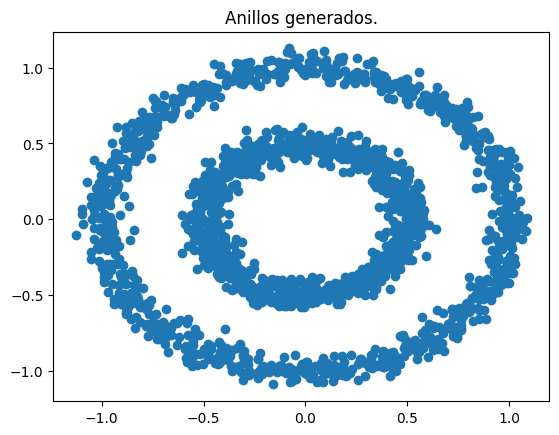

In [189]:
# Ahora vamos a visualizar el dataset completo, para ello vamos a utilizar
# la librería de visualización de datos matplotlib:
plt.scatter(X[:, 0], X[:, 1])
plt.title('Anillos generados.')
plt.show()

In [190]:
# Como dijimos antes, los puntos en X están guardados como un tensor de orden 2,
# Como tenemos 2000 puntos tendrá una dimensión de (2000, 2)
print('Dimensiones de X: ', X.shape)
# Por otro lado Y será un vector con los resultados, con 2000 datos:
print('Dimensiones de Y: ', Y.shape)


Dimensiones de X:  (2000, 2)
Dimensiones de Y:  (2000,)


In [191]:
# Una forma cómoda de ver un ejemplo de los datos puede ser verlos en un dataframe
# utilizando la librería pandas:
data_pd = pd.DataFrame()
data_pd['x'] = X[:, 0]
data_pd['y'] = X[:, 1]
data_pd['R'] = np.sqrt(X[:, 0]**2 + X[:, 1]**2)
data_pd['Label'] = Y

print('Vamos a mostrar los 10 primeros puntos, \n',
      'mostrando en x la coordenada x, en y la coordenada y\n',
      'en R la distancia al 0 a la que se encuentra el punto\n',
      'y en label la etiqueta.')
data_pd.head(10)

Vamos a mostrar los 10 primeros puntos, 
 mostrando en x la coordenada x, en y la coordenada y
 en R la distancia al 0 a la que se encuentra el punto
 y en label la etiqueta.


,x,y,R,Label
0,0.290097,-0.501504,0.579364,1
1,0.570569,0.757562,0.948393,0
2,-0.325011,0.419003,0.530279,1
3,-0.478270,-0.883670,1.004796,0
4,-0.461679,0.379692,0.597757,1
5,0.382015,-0.117310,0.399621,1
6,-0.046234,-1.053851,1.054865,0
7,0.036461,-0.463677,0.465108,1
8,-0.339066,-0.214009,0.400956,1
9,-0.904089,-0.535509,1.050784,0


Aquí podemos ver que los datos con R cercano a 1, pertenecen al círculo de fuera, y tienen como etiqueta '0' mientras que los puntos con R cercano a 0.5 pertenecen al círculo de dentro y tienen como etiqueta '1'.


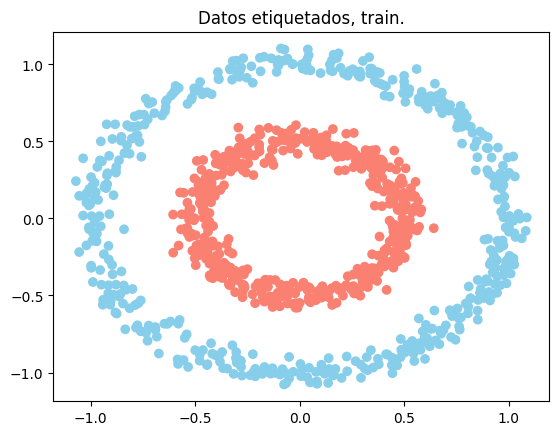

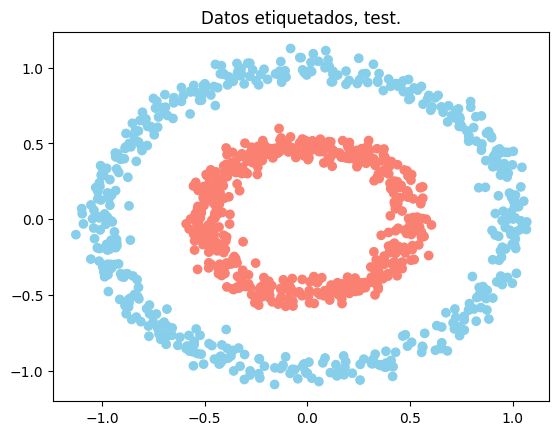

In [192]:
# Ahora vamos a aprovechar que podemos usar un mapa de color para
# Representar los puntos de cada categoría de un color diferente:

plt.scatter(X_train[:, 0], X_train[:, 1], c=['skyblue' if y == 0 else 'salmon' for y in Y_train])
plt.title('Datos etiquetados, train.')
plt.show()

plt.scatter(X_test[:, 0], X_test[:, 1], c=['skyblue' if y == 0 else 'salmon' for y in Y_test])
plt.title('Datos etiquetados, test.')
plt.show()

3. Cree y entrene los modelos utilizando los siguientes módulos:


### a. Utilizando Pytorch


In [193]:
# Importamos las librerías necesarias para crear la red con Torch:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import relu, tanh

In [194]:
# En torch hay que crear nuestra red neuronal como una clase que hereda de nn.Module:
class RedNeuronal(nn.Module):
    # Definimos el constructor de la clase:
    def __init__(self):
        super(RedNeuronal, self).__init__()
        self.layer1 = nn.Linear(2, 4)
        self.layer2 = nn.Linear(4, 8)
        self.layer3 = nn.Linear(8, 16)
        self.layer4 = nn.Linear(16, 8)
        self.layer5 = nn.Linear(8, 4)
        self.layer6 = nn.Linear(4, 1)

    # Definimos el método de propagación hacia delante:
    # Así definiremos como se conectan las capas.
    def forward(self, x):
        # Vamos a utilizar capas con función de activación tanh:
        # (Rectified Linear Unit)
        x = tanh(self.layer1(x))
        x = tanh(self.layer2(x))
        x = tanh(self.layer3(x))
        x = tanh(self.layer4(x))
        x = tanh(self.layer5(x))
        # A la última capa de pasamos una función sigmoide
        # para que los resultados estén entre 0 y 1
        x = torch.sigmoid(self.layer6(x))
        return x

    # Definimos un método para entrenar la red.
    def train(self, X, Y, num_epochs=100, lr=0.03, print_interval=20, stop_loss=0.0015,
              optimizer=optim.Adam, criterion=nn.BCELoss()):

        optimizer = optimizer(self.parameters(), lr=lr)

        LOSS = []
        ITER = []
        # Cremos un bucle para el entrenamiento.
        for i in range(num_epochs):
            # Calculamos el resultado actual.
            result = self(X)
            # Evaluamos la función de pérdida.
            loss = criterion(result, Y)
            # Imprimimos el estado del modelo cada cierto intervalo.
            if i % print_interval == 0:
                LOSS.append(loss.item())
                ITER.append(i)
                print(f'LOSS: {loss.item()}, ITER: {i}')
            # Actualizamos los parámetros del modelo:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # si se alcanza la tolerancia, se acaba el bucle de entrenamiento.
            if loss.item() < stop_loss:
                LOSS.append(loss.item())
                ITER.append(i)
                print(f'Entrenamiento finalizado:')
                print(f'LOSS = {LOSS[-1]}, n_ITER = {i}')
                break
            # Si no se alcanza se informa de ello.
            if i != 0 and i % (num_epochs - 1) == 0:
                print(f'Entrenamiento finalizado sin alcanzar el objetivo.')

        return LOSS, ITER


In [195]:
# También podríamos haber creado la red con nn.Sequential 
# quedando así una forma de definirla muy similar a como lo aprendimos en Keras.

class RedNeuronal2(nn.Module):
    def __init__(self):
        super(RedNeuronal2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.to(self.model[0].weight.dtype)
        return self.model(x)

    def train(self, X, Y, num_epochs=100, lr=0.03, print_interval=20, stop_loss=0.0015,
              optimizer=optim.Adam, criterion=nn.BCELoss()):

        optimizer = optimizer(self.parameters(), lr=lr)

        LOSS = []
        ITER = []

        for i in range(num_epochs):
            result = self(X)
            loss = criterion(result, Y)

            if i % print_interval == 0:
                LOSS.append(loss.item())
                ITER.append(i)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if loss.item() < stop_loss:
                LOSS.append(loss.item())
                ITER.append(i)
                print(f'Entrenamiento finalizado:')
                print(f'LOSS = {LOSS[-1]}, n_ITER = {i}')
                break

            if i != 0 and i % (num_epochs - 1) == 0:
                print(f'Entrenamiento finalizado en {num_epochs} epochs.')

        return LOSS, ITER

In [196]:
# Ahora vamos a pasar el modelo a la GPU de estar esta disponible para su uso.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Usando {device}')
# Pasamos el modelo al dispositivo:
modelo = RedNeuronal().to(device)
# Mostramos el modelo.
print(modelo)
modelo2 = RedNeuronal2().to(device)
print(modelo2)


Usando cpu
RedNeuronal(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=8, bias=True)
  (layer5): Linear(in_features=8, out_features=4, bias=True)
  (layer6): Linear(in_features=4, out_features=1, bias=True)
)
RedNeuronal2(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=4, bias=True)
    (9): ReLU()
    (10): Linear(in_features=4, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


In [197]:
# Ahora vamos a crear el optimizador del modelo:
# Vamos a utilizar el optimizador Adam.
optimizer = optim.Adam
# Y definimos la función de pérdida que vamos a usar:
# Vamos a utilizar como función del pérdida la binary cross entropy.
# la cual se utiliza para problemas de clasificación binaria.
criterion = nn.BCELoss()


In [198]:
# Transformamos los datos que tenemos en numpy a tensores de torch:
# para utilizarlos en nuestro modelo.
X_t = torch.from_numpy(X_train).float().to(device)
Y_t = torch.from_numpy(Y_train).float().to(device)
# Esto es para que tenga la forma de (n, 1) para poder realizar las operaciones.
Y_t = Y_t.reshape(-1, 1)

# Lo mismo con los datos de test.
X_v = torch.from_numpy(X_test).float().to(device)
Y_v = torch.from_numpy(Y_test).float().to(device)

Y_v = Y_v.reshape(-1, 1)

In [199]:
# Creamos el objeto red neuronal:
modelo_torch = RedNeuronal()


In [200]:
# Entrenamos la red neuronal usando el método train que hemos definido:
# (Se que estoy utilizando los que he puesto por defecto llamandolos, pero
# es solo con fines ilustrativos).
LOSS, ITER = modelo_torch.train(X_t, Y_t, num_epochs=10000,
                                optimizer=optimizer, criterion=criterion)


LOSS: 0.7087710499763489, ITER: 0
LOSS: 0.4416312277317047, ITER: 20
LOSS: 0.03707379102706909, ITER: 40
LOSS: 0.004645143169909716, ITER: 60
LOSS: 0.002079116879031062, ITER: 80
LOSS: 0.00154946802649647, ITER: 100
Entrenamiento finalizado:
LOSS = 0.0014971864875406027, n_ITER = 103


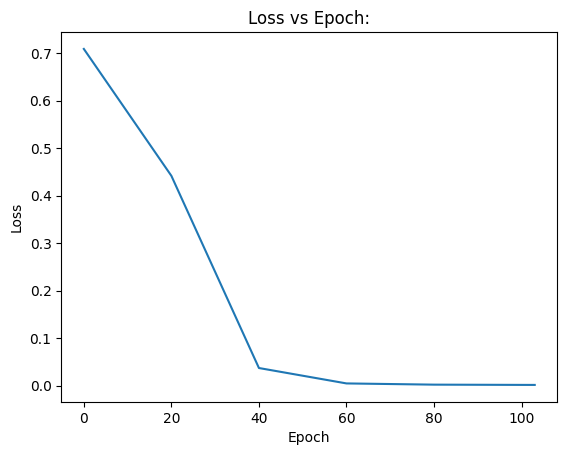

In [201]:
plt.plot(ITER, LOSS)
plt.title('Loss vs Epoch:')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

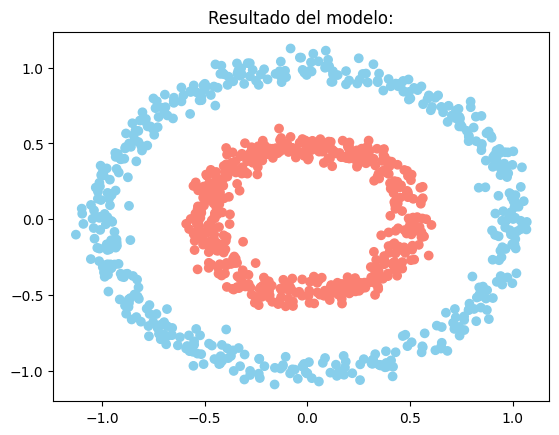

In [202]:
# Ahora vamos a mostrar los resultados:
result = modelo_torch(X_v)

# se pasa el resultado a la cpu como un array de numpy:
np_result = result.cpu().detach().numpy()

# Graficamos los resultados al igual que antes:
# Dado que en la última capa tenemos una función de activación sigmoide,
# los resultados están en el rango de 0 a 1. Los resultados inferiores a 0.5
# pertenecen a la clase '1' y los resultados mayores o iguales a 0.5 pertenecen a la clase '0'.
plt.scatter(X_test[:, 0], X_test[:, 1],
            c=['skyblue' if y < 0.5 else 'salmon' for y in np_result[:, 0]])
plt.title('Resultado del modelo:')
plt.show()

# Vamos a meter esto en el método de entrenamiento para que también nos devuelva la accuracy:


In [203]:
pred = [0 if y < 0.5 else 1 for y in np_result[:, 0]]

In [204]:
vector = pred == Y_test
vector = [0 if y == True else 0 for y in vector]
acc = 1-np.mean(vector)
print(acc)


1.0


## b. Utilizando Tensorflow y Keras


In [205]:
# Importamos las librerías que vamos a utilizar:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [217]:
modelo_keras = Sequential([
    Dense(4, input_shape=(2,), activation='tanh'),
    Dense(8, activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(8, activation='tanh'),
    Dense(4, activation='tanh'),
    Dense(1, activation='sigmoid')
])

modelo_keras.compile(
    optimizer='Adam', loss='BinaryCrossentropy', metrics='accuracy')

Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 0.6923 - accuracy: 0.5340 - val_loss: 0.6919 - val_accuracy: 0.5700
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6871 - accuracy: 0.6080 - val_loss: 0.6860 - val_accuracy: 0.5950
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6804 - accuracy: 0.6220 - val_loss: 0.6772 - val_accuracy: 0.6710
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.7300 - val_loss: 0.6642 - val_accuracy: 0.7020
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.7120 - val_loss: 0.6492 - val_accuracy: 0.6480
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6970 - val_loss: 0.6306 - val_accuracy: 0.7810
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.7600 - val_loss: 0.6121 - val_accuracy: 0.7450
Epoch 8/100
3

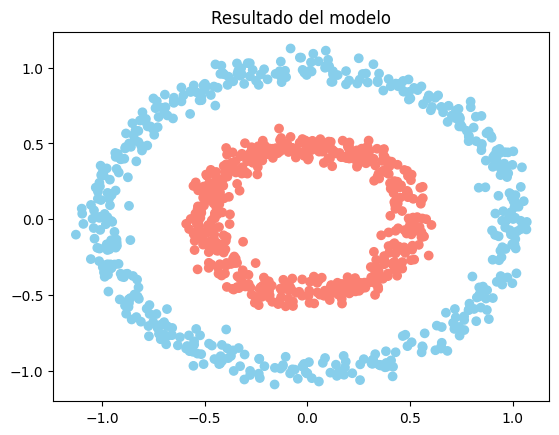

In [219]:
# Compilar el modelo
modelo_keras.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Definir el callback para early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Definir el callback para guardar los mejores pesos
checkpoint_callback = ModelCheckpoint(filepath='best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', patience=2)

# Entrenar el modelo con early stopping y guardar los mejores pesos
history = modelo_keras.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32, callbacks=[early_stopping, checkpoint_callback])

# Cargar los mejores pesos guardados
modelo_keras.load_weights('best_weights.h5')

# Obtener las predicciones del modelo
result = modelo_keras.predict(X_test)

# Graficar los resultados
plt.scatter(X_test[:, 0], X_test[:, 1], c=['skyblue' if y < 0.5 else 'salmon' for y in result])
plt.title('Resultado del modelo')
plt.show()


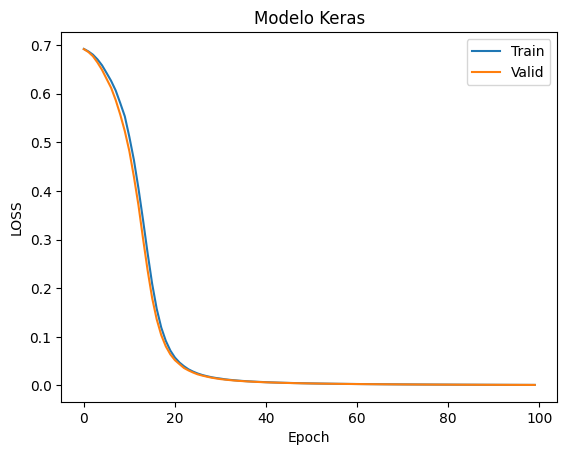

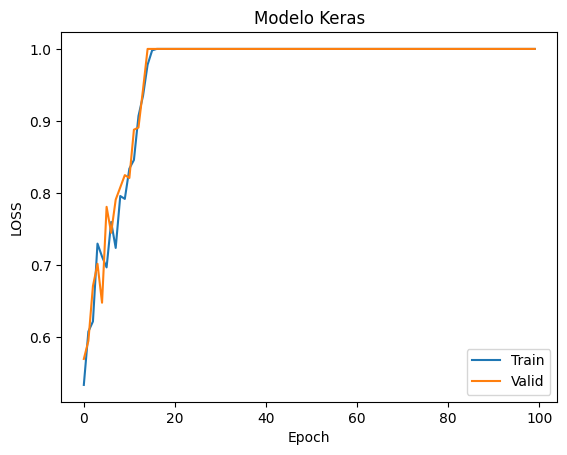

In [220]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

title = 'Modelo Keras'

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Valid')
plt.title(title)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.show()

plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Valid')
plt.title(title)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.show()

32/32 [==============================] - 0s 569us/step


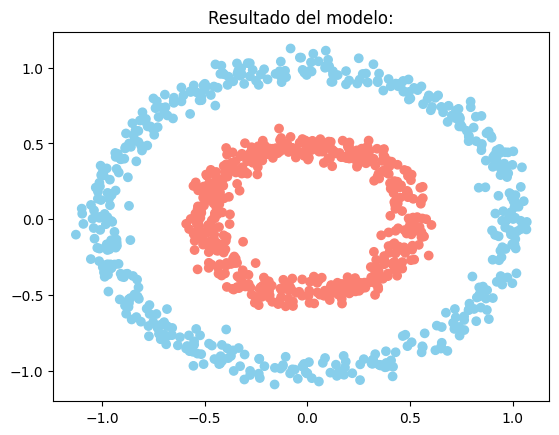

In [221]:
result = modelo_keras.predict(X_test)

plt.scatter(X_test[:, 0], X_test[:, 1],
            c=['skyblue' if y < 0.5 else 'salmon' for y in result])
plt.title('Resultado del modelo:')
plt.show()


## c. Utilizando Scikit-Learn


In [222]:
# Importamos las librerías necesarias:
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [223]:
# Creamos el modelo:
modelo_sklearn = MLPClassifier(hidden_layer_sizes=[8, 16, 8],
                              activation='tanh',
                              solver='adam',
                              learning_rate_init=0.01,
                              verbose=True,
                              max_iter=1000)


In [224]:
# Entrenamos al modelo:
history = modelo_sklearn.fit(X_train, Y_train)

# Obtener la pérdida durante el entrenamiento
loss = modelo_sklearn.loss_curve_


y_pred = modelo_sklearn.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)

Iteration 1, loss = 0.70520604
Iteration 2, loss = 0.68238643
Iteration 3, loss = 0.66458174
Iteration 4, loss = 0.62725618
Iteration 5, loss = 0.59178017
Iteration 6, loss = 0.56466525
Iteration 7, loss = 0.54063158
Iteration 8, loss = 0.51879297
Iteration 9, loss = 0.49210771
Iteration 10, loss = 0.46106058
Iteration 11, loss = 0.42487475
Iteration 12, loss = 0.38055872
Iteration 13, loss = 0.33028787
Iteration 14, loss = 0.27408627
Iteration 15, loss = 0.22019706
Iteration 16, loss = 0.17213902
Iteration 17, loss = 0.13246287
Iteration 18, loss = 0.10097027
Iteration 19, loss = 0.07633747
Iteration 20, loss = 0.05758191
Iteration 21, loss = 0.04454395
Iteration 22, loss = 0.03511067
Iteration 23, loss = 0.02857865
Iteration 24, loss = 0.02382045
Iteration 25, loss = 0.02031608
Iteration 26, loss = 0.01773476
Iteration 27, loss = 0.01565889
Iteration 28, loss = 0.01396310
Iteration 29, loss = 0.01263358
Iteration 30, loss = 0.01151271
Iteration 31, loss = 0.01056175
Iteration 32, los

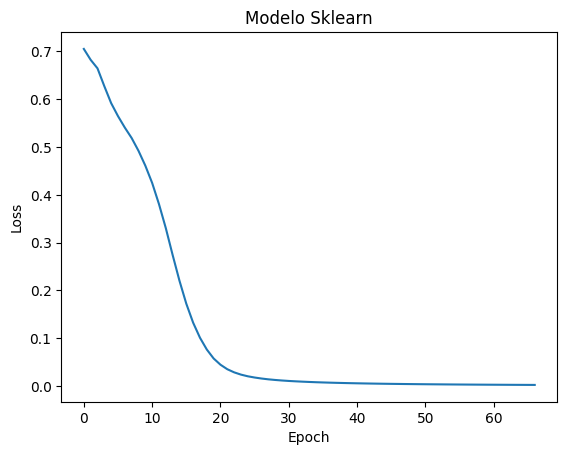

In [225]:
# Gráfica de pérdida
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Título
plt.title('Modelo Sklearn')

# Mostrar la gráfica
plt.show()

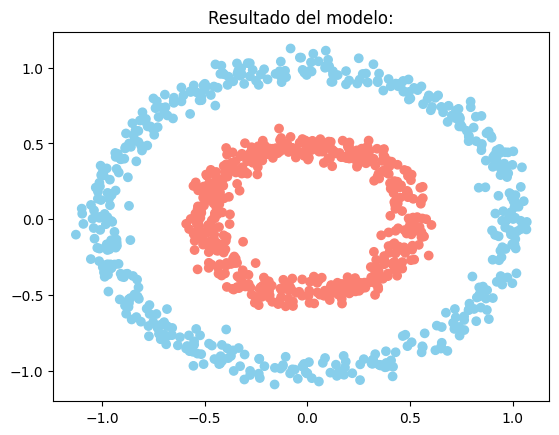

In [226]:
result = modelo_sklearn.predict(X_test)

plt.scatter(X_test[:, 0], X_test[:, 1],
            c=['skyblue' if y < 0.5 else 'salmon' for y in result])
plt.title('Resultado del modelo:')
plt.show()


## 4. Compare los resultados obtenidos de cada modelo


Los 3 modelos son muy similares ya que los hice casi con la misma topología y funciones, pero vamos a hacer una mayor visualización de los resultados para compararlos, para ello vamos a representar una 'región de decisión' para ver como se ajustan los resultados:


In [227]:

def plot_decision(model, X, y, title = 'Decision Boundary'):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    grid_points = np.c_[xx.ravel(), yy.ravel()]

    try:
        y_pred = model.predict(grid_points)
    except:
        x_t = torch.from_numpy(grid_points).float()
        with torch.no_grad():
            y_pred = model(x_t).detach().numpy()

    y_pred = y_pred.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel(f'X')
    plt.ylabel('Y')
    plt.title(str(title))
    plt.colorbar()
    

313/313 [==============================] - 0s 599us/step


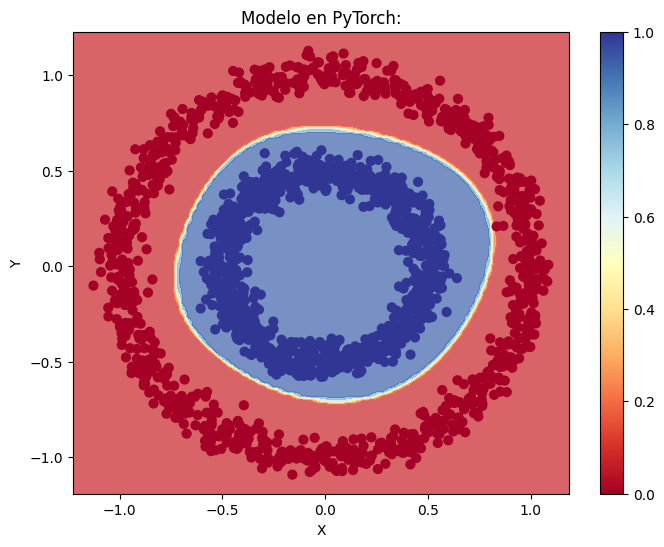

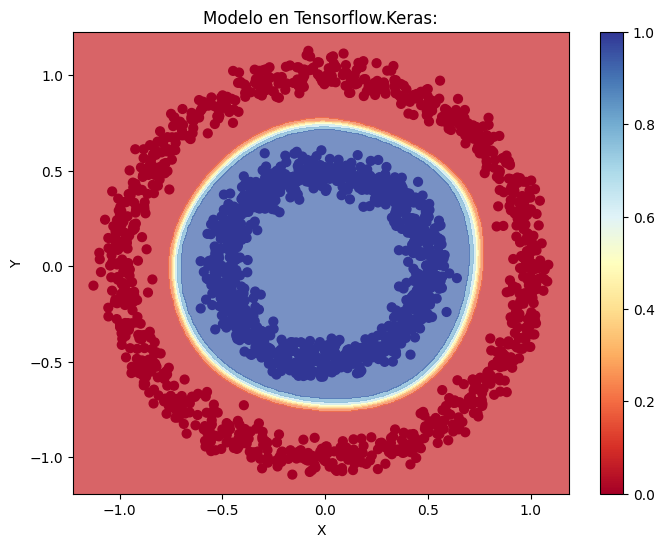

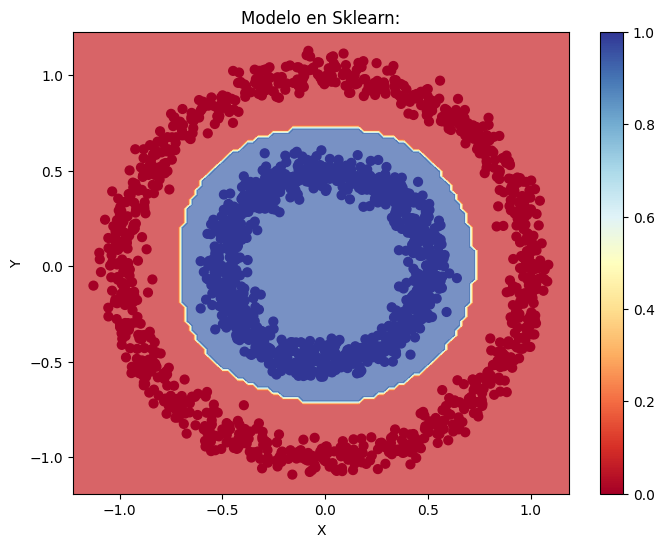

In [229]:

plot_decision(model=modelo_torch,X=X,y=Y, title = 'Modelo en PyTorch:')

plot_decision(model=modelo_keras,X=X,y=Y, title = 'Modelo en Tensorflow.Keras:')

plot_decision(model=modelo_sklearn,X=X,y=Y, title = 'Modelo en Sklearn:')


Como podemos observar en las gráficas, los modelos creados en PyTorch, Keras y Sklearn, son muy similares lo cual era de esperar ya que hemos elegido prácticamente la misma arquitectura para los 3 modelos, los 3 modelos han conseguido clasificar los puntos con un 100% de acierto.

Por otro lado, podemos evaluar la 'comodidad' a la hora de obtener métricas y realizar el proceso de entrenamiento, con torch, al ser este una forma de más cercana a definir la red directamente es de 'más bajo nivel', es necesario definir la clase de la red neuronal con la arquitectura del modelo por lo que es menos cómodo a la hora de hacer proyectos sencillos pero tiene mayor capacidad para hacer modelos y métodos de entrenamiento totalmente personalizados, también te permite obtener todas las métricas que tu quieras pero tienes que definirlas, por otro lado, keras está en un nivel intermedio, te permite definir las capas del modelo individualmente y tener cierta personalización en el modelo pero es mucho más cómodo y accesible que torch, aunque menos personalizable, también a la hora de obtener métricas puedes utilizar métricas predefinidas y distintos calbacks ya hechos para por ejemplo guardar los mejores pesos o parar el entrenamiento y además puedes crear los tuyos propios. Por último el modelo en sklearn es el de más 'alto nivel' ya que trabajamos a nivel de modelos ya creados y solo modificamos la arquitectura un poco y la función de activación, siendo el más accesible pero el que tiene menor capacidad para personalizar el modelo.